# IPSC Model Detection Example

The model is comprised of a few steps that will be demonstrated here. The first step will be **importing and preprocessing** of files followed by **feature extraction**, **prediction** and  finally **value export**. 

These steps are implemented as a method from the RecordingFile class which will be demonstrated here.

## Import and Prep

In [1]:
import pandas as pd
import numpy as np
import os
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import tensorflow
import keras
from keras.models import Sequential
from keras.wrappers.scikit_learn import KerasClassifier
from keras.layers import Dense, Dropout, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D, MaxPooling1D, Conv1D
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy import integrate
from scipy.signal import find_peaks
from scipy import signal
import pyabf
from tqdm import tqdm
import pickle
from Classes import *

## Simplified Function

To simply load the file and make predictions, you can use the following functions.

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1600 out of 1600 | elapsed:    0.2s finished


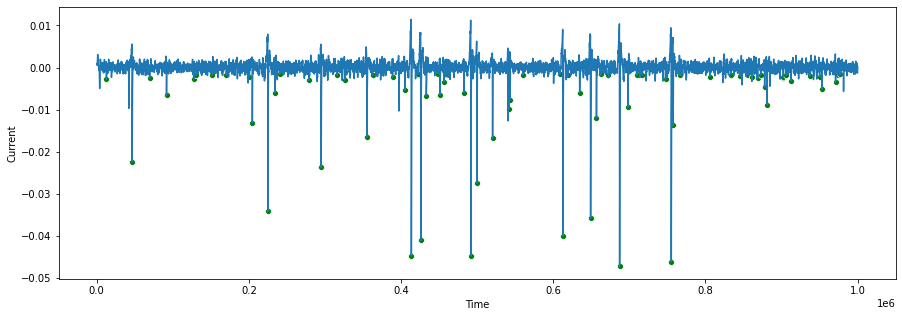

In [119]:
# Path to the test file
test_file_path = '7_30_2019 264 Continuous Export.abf'

# Creation of the RecordingFile object
abf = RecordingFile(test_file_path)

# Carries out necessary functions and makes predictions
df = abf.create_display_df()

# Plot the figure which displaces the filtered trace and the predictions
plt.figure(figsize=(15,5))
sns.scatterplot('Time','Current', data=df, color='g')
plt.plot(abf.processed['Current_F'])
plt.show()

For more details about each of the steps in the pipeline, continue reading! 

## Importing a File

The first step for the model is importing a single file. Details on how to import and analyze a batch of recordings simultaneously will be detailed later. Importing a file is done by creating a RecordingFile object with the path to the recording file as an argument. The example file is inlcuded in the project for simplicity. For the sake of speed, we will only load the first portion of a recording by switch thing argument Slicer to be True, which is natively set to False. 

The abf_init method returns a Pandas DataFrame with two columns, Time and Current. The current can be visualized below.

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1600 out of 1600 | elapsed:    0.2s finished


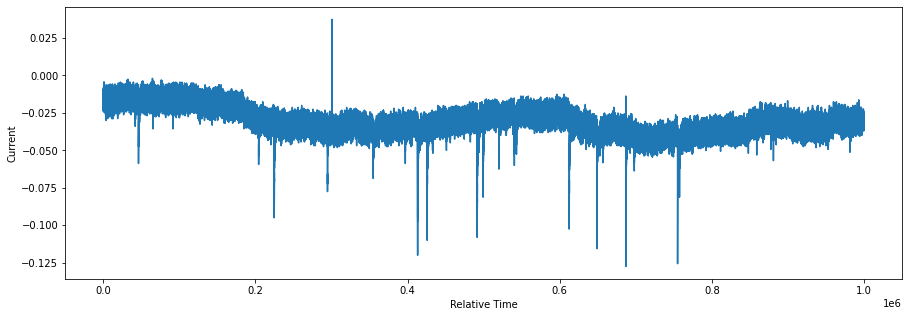

In [48]:
# Path to the test file
test_file_path = '7_30_2019 264 Continuous Export.abf'

# Creation of the RecordingFile object
abf = RecordingFile(test_file_path)
trace = abf.abf_init

# Display the recording that was loaded
plt.figure(figsize=(15,5))
plt.plot(trace['Current'])
plt.xlabel('Relative Time')
plt.ylabel('Current')
plt.show()

## Filtering and Smoothing

Before feature extraction and prediction can occur, the data should be filtered and smoothed. This helps adjust for electrode drift, decreases noise, slightly downsamples the data to speed processing, and acts as a relative normalizer. For more details on why and how this was done, see the manuscript. 

First the recording is filtered using THIS function from the RecordingFile class. Then the smoothing function is applied as THIS function from the same class. 

In [49]:
# Filters the trace
filt = abf.apply_filter(trace)

# Smoothes the trace
smth = abf.smooth_trace(filt)

These functions can be visualized below.

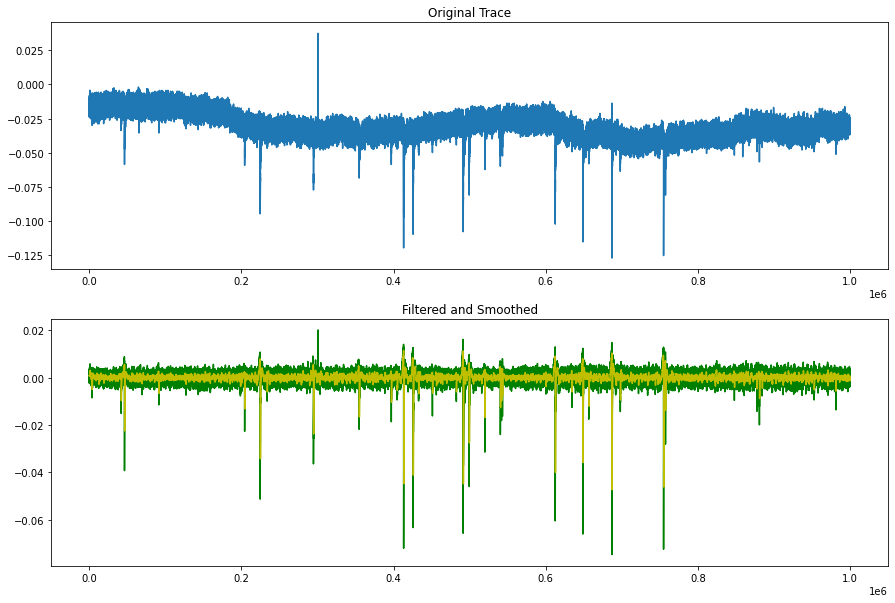

In [50]:
# Visualizes all three traces side by side
fig, axs = plt.subplots(2, figsize = (15,10))

axs[0].plot(trace['Current'])
axs[1].plot(filt['Current_F'], color='g')
axs[1].plot(smth['Current_F'], color='y')

axs[0].set_title('Original Trace')
axs[1].set_title('Filtered and Smoothed')

plt.show()

## Finding Potential Peaks

After preprocessing is complete, we then try to find all possible places where peaks might occur. This can save time on training and prediction. For more details on the tools used to do this, check the manuscript as well as this LINK.

Once again, finding potential peaks can be done using a function from the RecordingFile class. Fist, the recording must be inverted, then passed to the find_pot_peaks function. This will return a DataFrame with two columns: Time and Current. 

In [51]:
# Inverts the smoothed trace
inv_trace = abf.invert_trace(smth)

# Creates DataFrame of potential peaks
pot_peaks = abf.find_pot_peaks(inv_trace)

These peaks can now be displayed on top of the inverted recording. Notice that potential peaks are over exaggerated.

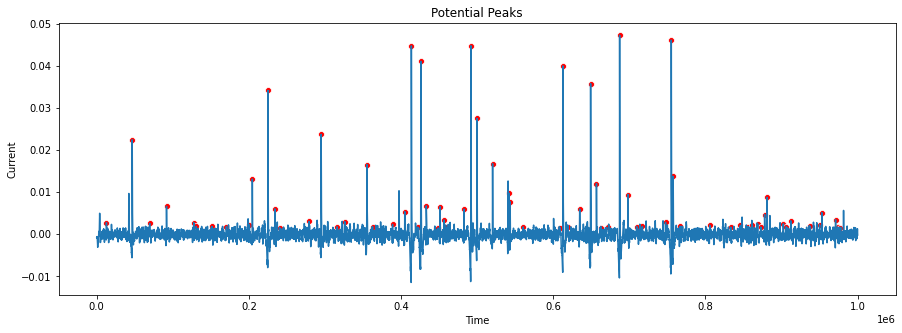

In [52]:
# Displays the potential peaks on the inverted trace
plt.figure(figsize=(15,5))
sns.scatterplot(x='Time', y='Current', data=pot_peaks, color='r')
plt.plot(inv_trace['Current_F'])
plt.title('Potential Peaks')
plt.show()

## Feature Extraction

Traces are first split into 0.8 second chunks with the proposed peak in the center. Features were extracted using a variety of tools described in the 'Methods' section of our manuscript. This resulted in the following 7 features: percent baseline, peak height, tau, r2 decay, AUC, rise time, and rise time percent baseline. The resulting features and labels then entered the model training phase of the pipeline.

Feature extraction has been packaged into a single function for ease of implementation with our model. For more details on usage of individual feature extraction methods, see Classes.py under this function name, or reference our manuscript.

In [53]:
# Extracts features for model predictions
features = abf.peak_info
features.head()

,Time,Percent Basleine,Peak Heights,Tau,r2 Decay,AUC,Rise Time,Rise Time Percent Baseline
12731,12731,0.001,0.002786,157.880983,0.940240,0.477250,181,0.001
46612,46612,0.001,0.022453,221.710514,0.992361,5.355238,184,0.001
69533,69533,0.001,0.002569,182.841901,0.959603,0.561483,273,0.001
91687,91687,0.001,0.006622,188.244057,0.932160,1.270068,200,0.001
127477,127477,0.001,0.002768,113.911342,0.932239,0.327544,196,0.001


Examples of chunks can be seen here:

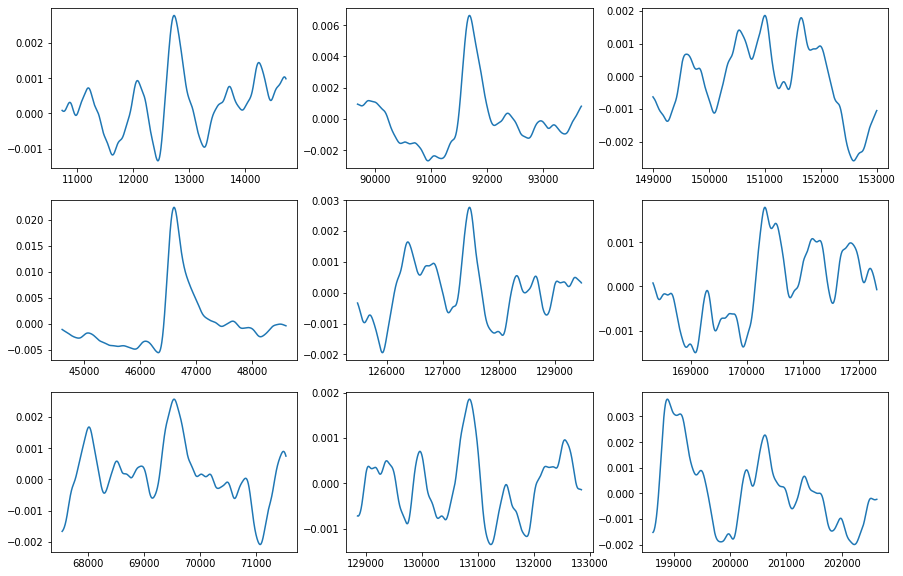

In [96]:
# Displays sample chunk tracings, change fign value to make grids of varying sizes
fign = 3 
fig, axs = plt.subplots(fign, fign, figsize=(15,10))

rn = 0
cn = 0
for i in range(0,(fign**2)):
        
    t = features['Time'].iloc[i]
    
    chnk = PeakChunk(inv_trace, t)
    ex = chnk.chunk
     
    axs[cn,rn].plot(ex)
    
    if cn + 1 >= (fign):
        cn = 0
        rn = rn + 1
    else:
        cn = cn + 1

## Prediction

Finally, predictions can be made on the dataset by loading and predicting the trained model. This is also built into the RecordingFile class. These functions will return a list of predictions for each peak. 

In [100]:
# Makes predictions
preds = abf.predict
preds[:5]

[0, 1, 0, 1, 0]

This can be exported together with the time domaine and current by using the following function:

In [103]:
df = abf.create_display_df()
df.head()

,Time,Current,Prediction
0,12731,-0.002786,0
1,46612,-0.022453,1
2,69533,-0.002569,0
3,91687,-0.006622,1
4,127477,-0.002768,0


The final display is shows the reverted trace with the predicted peaks.

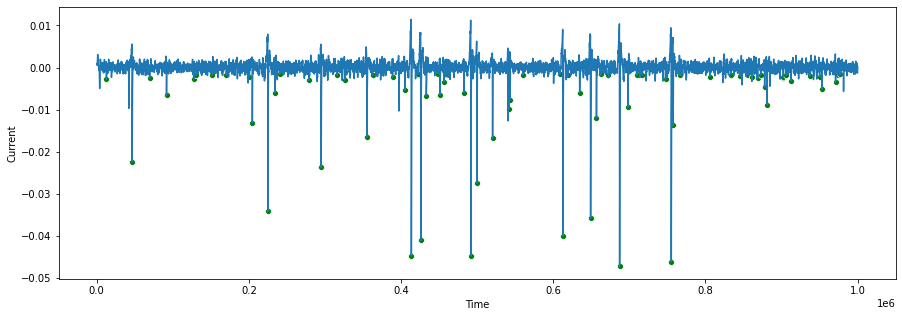

In [110]:
plt.figure(figsize=(15,5))
sns.scatterplot('Time','Current', data=df, color='g')
plt.plot(smth['Current_F'])
plt.show()

## Batch Processing 

It is often necessary to predict and analyze multiple recordings at the same time. The basics of this have been written but not extensively tested. However, here is how the basic tool works. A column for drug name can be added for the batch processing of a number of files with the same drug conditions. 

In [3]:
batch = BatchAnalysis('Batch_Files', drg_name=None)
df = batch.iter_preds()
df.head()

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1600 out of 1600 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1600 out of 1600 | elapsed:    0.2s finished


,Time,Current,Prediction,Percent Basleine,Peak Heights,Tau,r2 Decay,AUC,Rise Time,Rise Time Percent Baseline,File Name
0,12731,-0.002786,0,0.001,0.002786,157.880983,0.940240,0.477250,181,0.001,7_30_2019 264 Continuous Export_copy1.abf
1,46612,-0.022453,1,0.001,0.022453,221.710514,0.992361,5.355238,184,0.001,7_30_2019 264 Continuous Export_copy1.abf
2,69533,-0.002569,0,0.001,0.002569,182.841901,0.959603,0.561483,273,0.001,7_30_2019 264 Continuous Export_copy1.abf
3,91687,-0.006622,1,0.001,0.006622,188.244057,0.932160,1.270068,200,0.001,7_30_2019 264 Continuous Export_copy1.abf
4,127477,-0.002768,0,0.001,0.002768,113.911342,0.932239,0.327544,196,0.001,7_30_2019 264 Continuous Export_copy1.abf


The following can be used to explore feature relationships.

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/seaborn/distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)


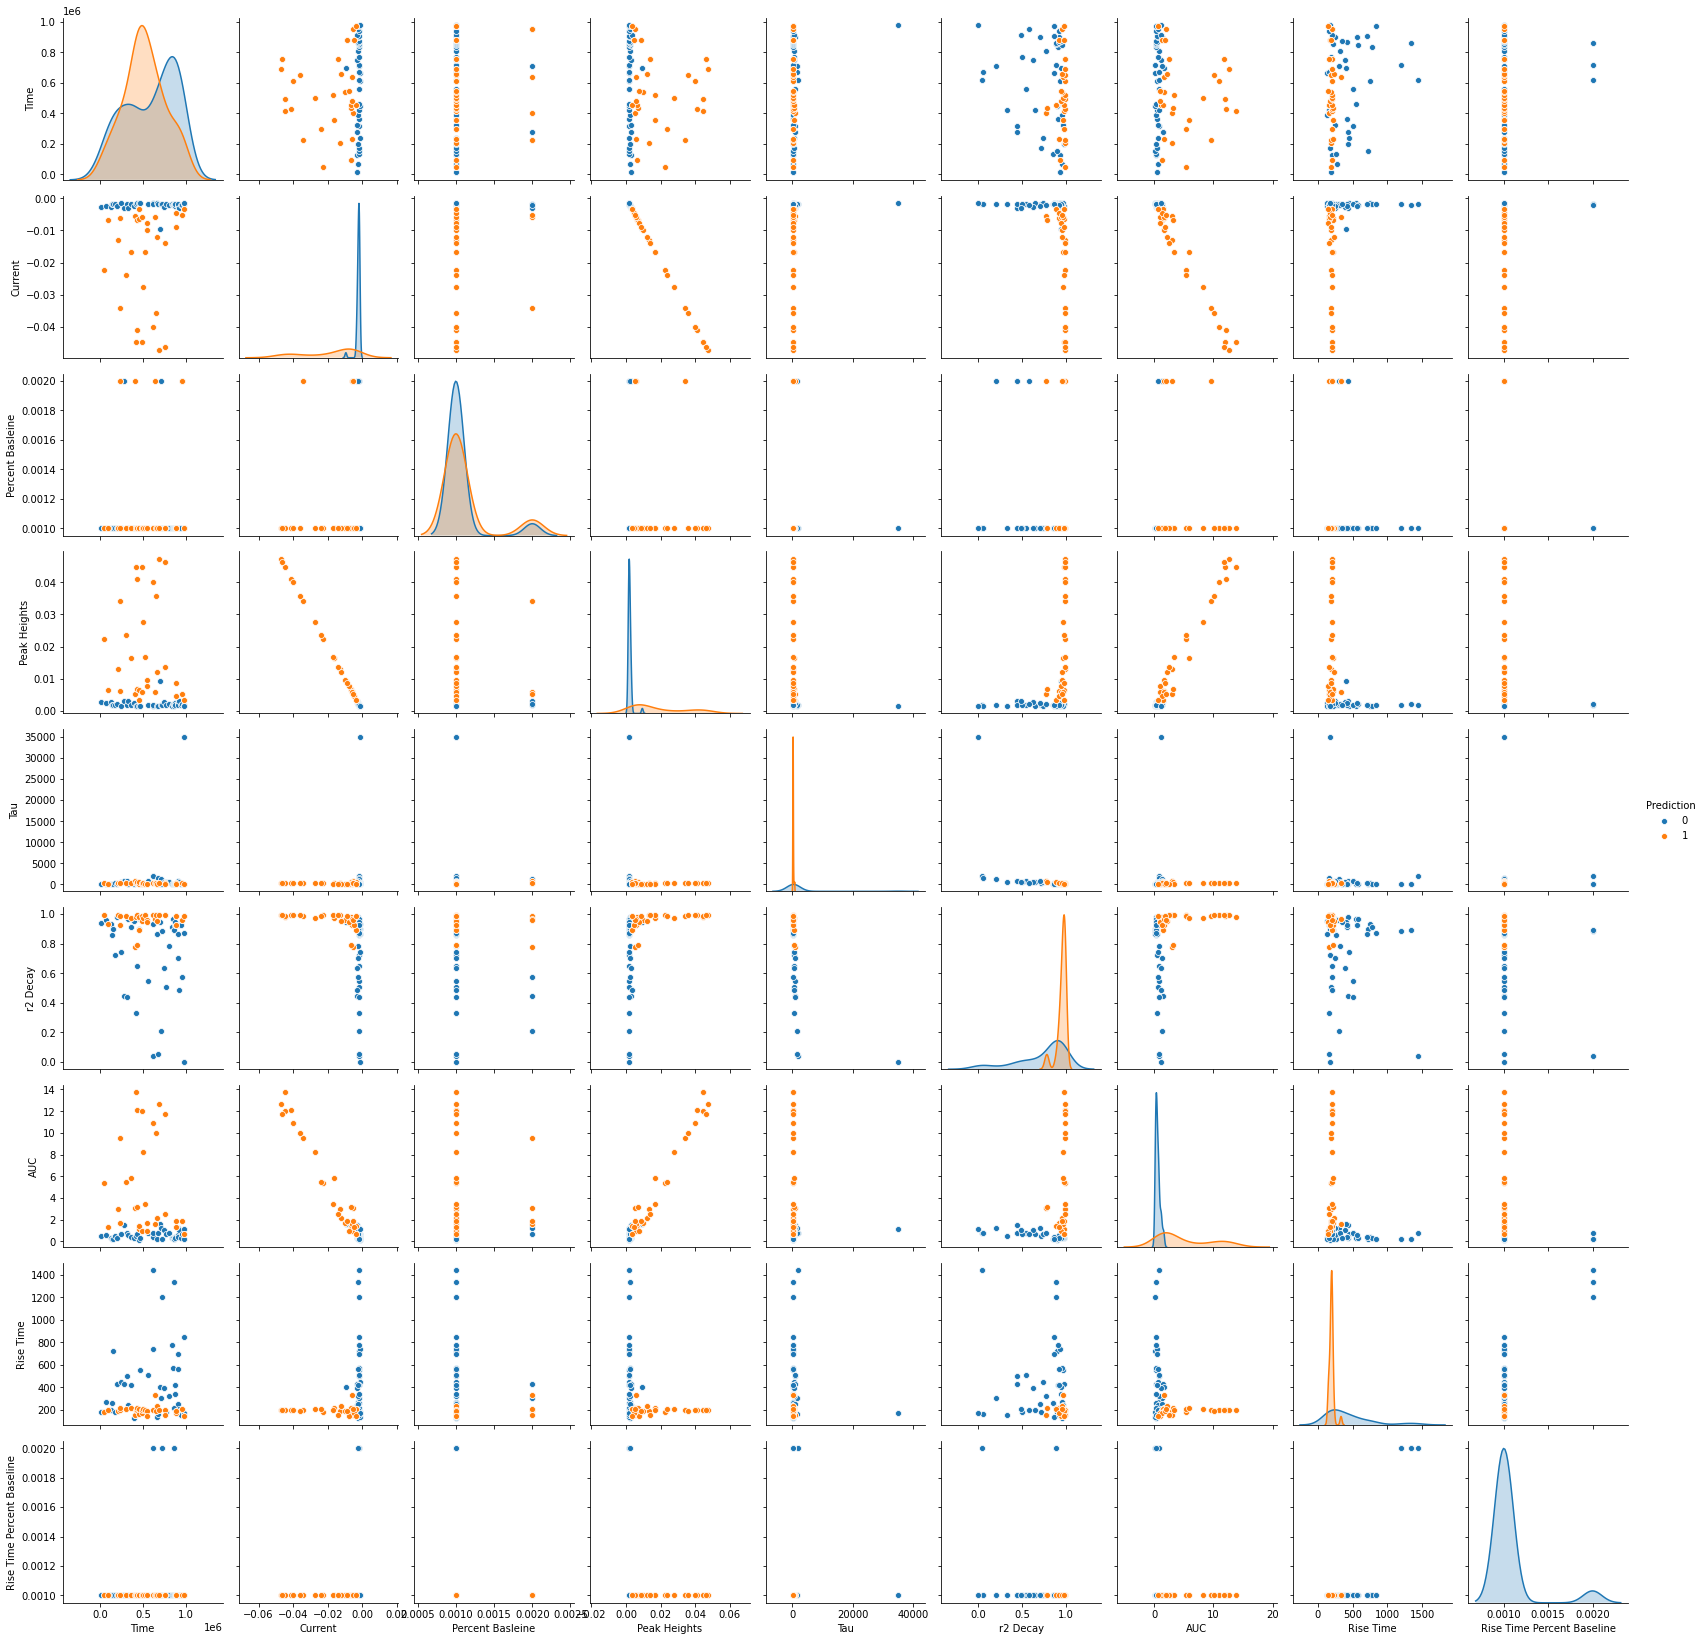

In [8]:
sns.pairplot(df, hue='Prediction')
plt.show()